## Pupil Gluing Characterisation 🖌️

This notebook:
1. Calculates the Zernike coefficients on two separate starphire plates
2. Calculates the Zernike coefficients on the glued starphire setup

Existing system aberrations are loaded and can be calculated using System_Aberrations.ipynb

In [1]:
import dLux as dl
import dLux.utils as dlu

import jax.numpy as jnp
import numpy as np
import jax.random as jr
import jax.scipy as jsp
from jax import vmap  
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update('jax_disable_jit', False)

import zodiax as zdx
import optax
from tqdm.notebook import tqdm

from skimage.io import imread
from skimage.filters import window
import skimage as ski
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 15

### System Parameters

In [2]:
# ------- Physical Parameters ---------------------------------------------------------------------#
aperture_npix = 512           # Number of pixels across the aperture
aperture_diameter = 126e-3    # (m)
spider_width = 20e-3          # Spider width (m)
spider_angle =270             # Spider angle (degrees), clockwise, 0 is spider pointing vertically up
coords = dlu.pixel_coords(npixels=aperture_npix, diameter=aperture_diameter)
circle = dlu.circle(coords=coords, radius=aperture_diameter/2) 

# Observations wavelengths (bandpass of 530-640nm)
red_laser_wl =  635e-09  # for laser data
green_laser_wl = 520e-09  # for laser data
wf_npixels = aperture_npix  # Number of pixels across the wavefront
wf_diam = aperture_diameter             # Diameter of initial wavefront to propagate wavefront (m)

# Detector parameters (BFS-U3-200S6-BD)
BFS_px_sep = 2.4e-6 *1e3        # pixel separation (mm)
f_det = 1300#1350                    # Focal length from OAP2 to detector (mm) 
px_ang_sep = 2*np.arctan( (BFS_px_sep/2)/f_det ) # angular sep between pixels (rad)

# Simulated Detector
psf_npix = 40                 # Number of pixels along one dim of the PSF
psf_hlf_sz = int(psf_npix/2)             # half window sz of cropped data
oversample = 1                 # Oversampling factor for the PSF
psf_pixel_scale = dlu.rad2arcsec(px_ang_sep) # arcsec (to match detector plate scale) 80e-4 

# Detector response (gamma curve)
alpha = np.load("data/80us_detector/ALPHA_norm.npy")
beta = np.load("data/80us_detector/BETA_norm.npy")
gamma = np.load("data/80us_detector/GAMMA_norm.npy")


### Simulated Setup

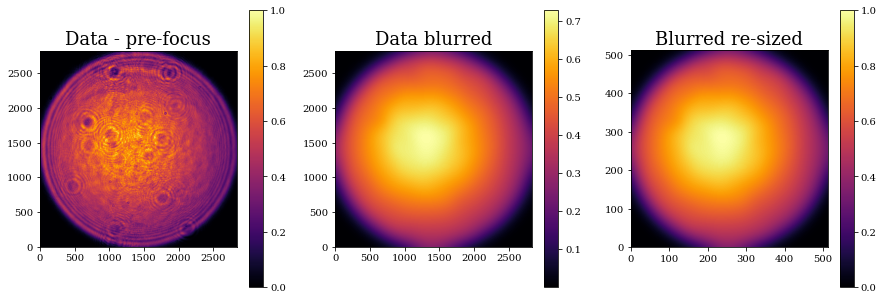

In [3]:
fname = "data/intensity/15_07_intensity_dist.png"
data = imread(fname, as_gray=True) 
manual_lim = [1363,4203,386,3214]
data = data[manual_lim[2]:manual_lim[3], manual_lim[0]:manual_lim[1]]
data = (data - data.min())/(data.max()-data.min())

blurred = ski.filters.gaussian(data, sigma=(120, 120))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(data)
plt.title("Data - pre-focus")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(blurred)
plt.title("Data blurred")
plt.colorbar()
plt.subplot(1,3,3)
intensity_dist = resize(blurred, (aperture_npix, aperture_npix))
intensity_dist = (intensity_dist - intensity_dist.min())/(intensity_dist.max()-intensity_dist.min()) # re-map from 0-1
plt.title("Blurred re-sized")
plt.imshow(intensity_dist)
plt.colorbar()


#### todo 
load in system aberration zernike coeffs

In [ ]:
#TODO

4.839528300805434e-08
Total flux: 132.498237585098


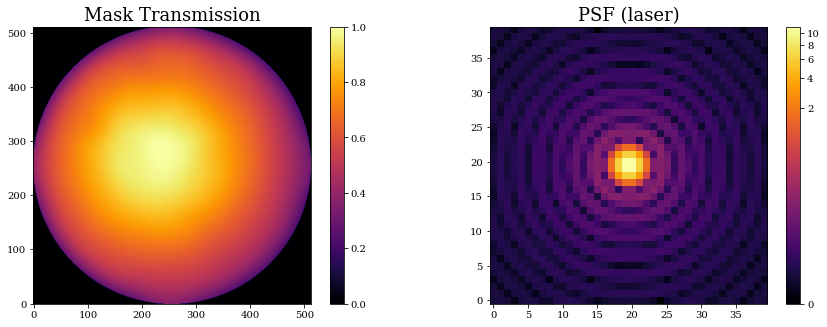

In [4]:
# --- Simulate Spider -----------------------------------------------------------------#
# spider = dlu.spider(coords=coords, width=spider_width, angles=[spider_angle])
transmission = circle*intensity_dist#dlu.combine([circle, spider])*intensity_dist

# Zernike aberrations
zernike_indicies = jnp.arange(4, 15) # up to 14th noll idxs (excluding piston)
coeffs = jnp.zeros(zernike_indicies.shape)
basis = dlu.zernike_basis(js=zernike_indicies, coordinates=coords, diameter=aperture_diameter)

# Using PointSources instead of single PointSource object to overcome float grad issue when solving for flux
# https://github.com/LouisDesdoigts/dLux/issues/271 
src = dl.PointSources(wavelengths=[red_laser_wl], flux =jnp.asarray([1e8],dtype=float))


layers = [
    ('aperture', dl.layers.BasisOptic(basis, transmission, coeffs, normalise=False)),
]

# Construct Optics
optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)


instrument = dl.Telescope(optics, ('source', src))
sim_psf = instrument.model()
print(sim_psf.min())

# Show setup and transmission results
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
# plt.imshow(transmission*instrument.optics.intensity_prof.transmission)
plt.imshow(transmission)
plt.colorbar()
plt.title('Mask Transmission')
plt.subplot(1,2,2)
norm_psf = PowerNorm(0.2, vmax=sim_psf.max(), vmin=sim_psf.min())
print("Total flux: {}".format(sim_psf.sum()))
plt.imshow(sim_psf, norm=norm_psf)
plt.title('PSF (laser)')
plt.colorbar()


### Load in single Starphire data

#### Phase Retrieval

In [5]:
params = [
    'aperture.coefficients',
    'source.position',
    'source.flux', 
    ]

@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_poisson(model, data):

    simu_psf = model.model()

    loss = -jsp.stats.poisson.logpmf(k=simu_psf, mu=data).sum()

    return loss

learning_rate = 1e-9
optimisers = [
            optax.adam(learning_rate=learning_rate),
            optax.adam(learning_rate=learning_rate),
            optax.adam(learning_rate=1e6),
              ]


### Lets loop this

In [6]:
# Location on detector 
row_start, col_start = 1670, 2580 # Start coord of window on det where data was taken
row_len, col_len = 86, 76   # window size of recorded data

alpha_cropped = alpha[row_start:row_start+row_len, col_start:col_start+col_len]
beta_cropped = beta[row_start:row_start+row_len, col_start:col_start+col_len]
gamma_cropped = gamma[row_start:row_start+row_len, col_start:col_start+col_len]

img_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/15_08_green_starphire1_80us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/15_08_green_starphire2_80us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/15_08_red_starphire1_80us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/15_08_red_starphire2_80us_0gain_img_stack_batch_0.npy",
    
]
bckgnd_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/15_08_bckgnd_starphire2_80us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/15_08_bckgnd_starphire2_80us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/15_08_bckgnd_starphire1_80us_0gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/non_glued/15_08_bckgnd_starphire1_80us_0gain_img_stack_batch_0.npy",
]
still_frame_idxs = [
    166, 17, 107, 8 # find_still_frame.py
]

epochs = [
    7000, 15000,7000,7000,
]

Loss:   0%|          | 0/7000 [00:00<?, ?it/s]

Optimised Position: [[1.40896864e-06 1.76071068e-06]]
Flux: [1.29209876e+08]
Coefficients: [-3.36716683e-09  7.28857042e-08  8.48337637e-09 -8.03893957e-09
  9.16742805e-09 -1.10368175e-08 -7.24485270e-09 -7.64922429e-09
 -1.29670066e-09 -1.01013848e-08 -3.70199503e-09]


Loss:   0%|          | 0/15000 [00:00<?, ?it/s]

Optimised Position: [[1.18884460e-05 2.88709606e-06]]
Flux: [2.38315957e+08]
Coefficients: [ 2.00402610e-07  1.12387127e-07  2.60934278e-07 -2.29890614e-08
 -9.42430073e-08 -4.80208634e-08 -7.58921141e-08  1.48755549e-08
  2.01834514e-08  2.44716622e-10  1.86442259e-08]


Loss:   0%|          | 0/7000 [00:00<?, ?it/s]

Optimised Position: [[8.12769565e-07 1.67442115e-06]]
Flux: [1.34470252e+08]
Coefficients: [-1.29460683e-08  7.26408837e-08  1.06917113e-08 -5.44372553e-09
  9.78972536e-09 -7.51823592e-09 -4.36786976e-09 -8.03314544e-09
  3.88063927e-10 -4.31227390e-09  4.02767151e-09]


Loss:   0%|          | 0/7000 [00:00<?, ?it/s]

Optimised Position: [[8.08019058e-07 6.12478827e-07]]
Flux: [2.71718165e+08]
Coefficients: [ 1.68043940e-07  1.33070531e-07  2.04255329e-07  2.62660453e-09
 -7.71008113e-09  1.05609495e-08 -2.30453107e-08  2.07885123e-08
  2.14625071e-08  1.30002479e-08  4.27789124e-09]


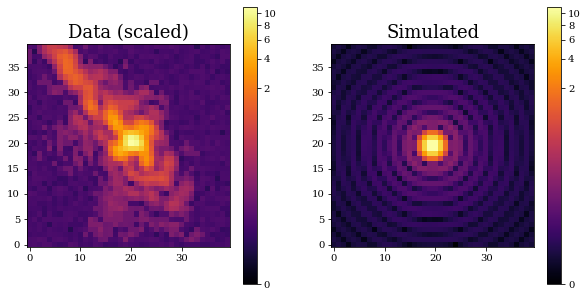

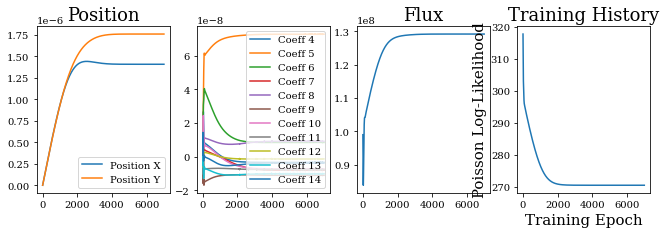

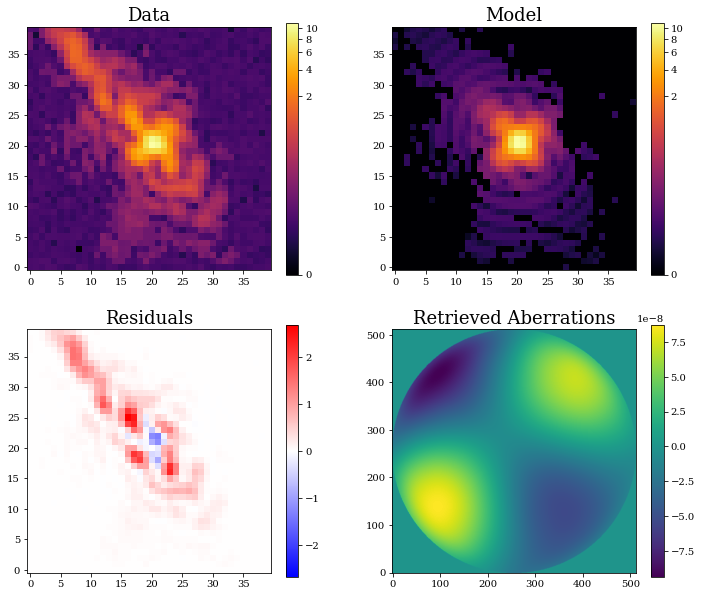

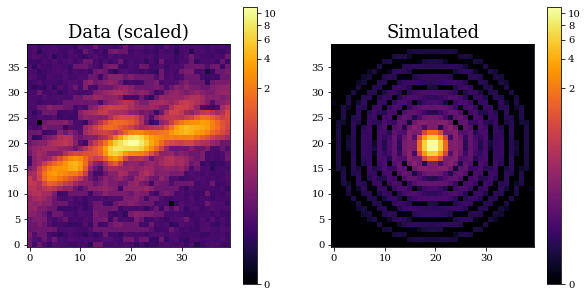

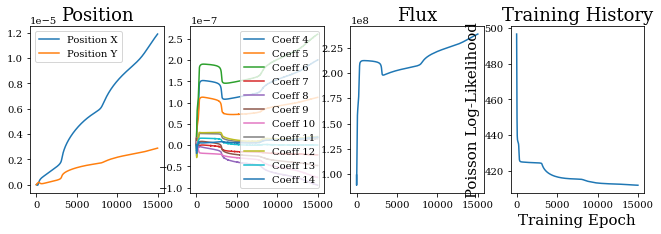

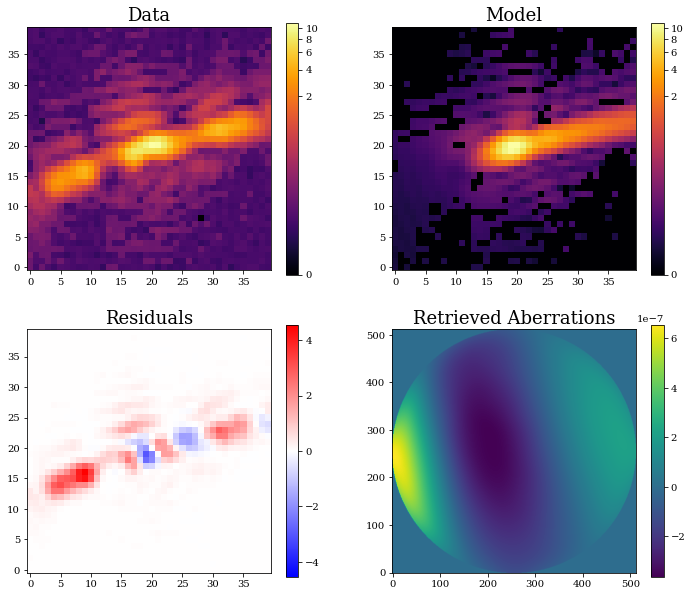

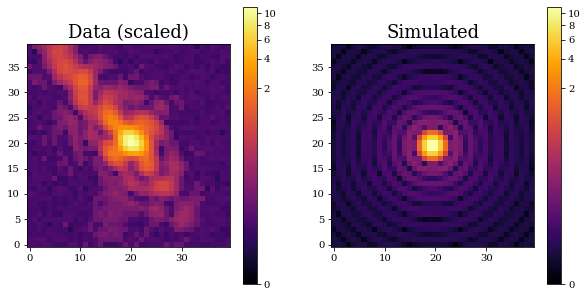

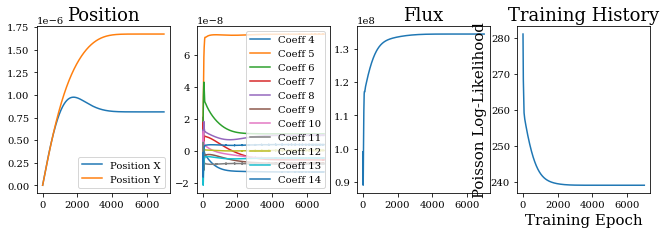

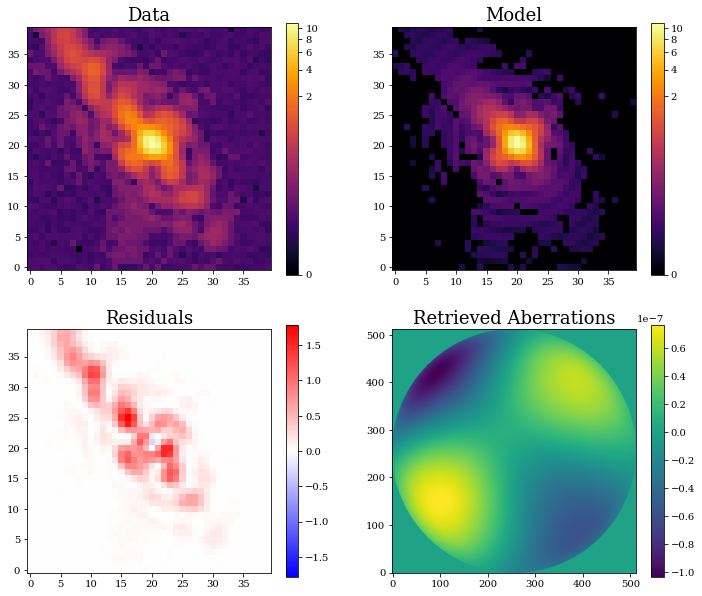

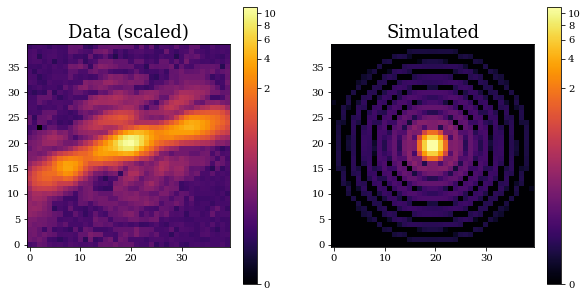

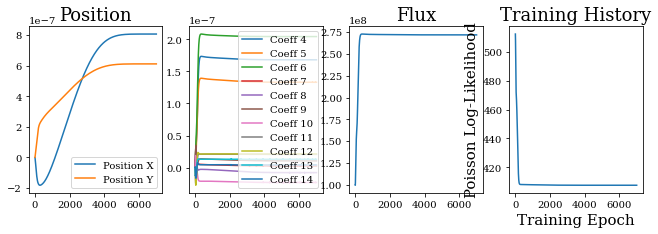

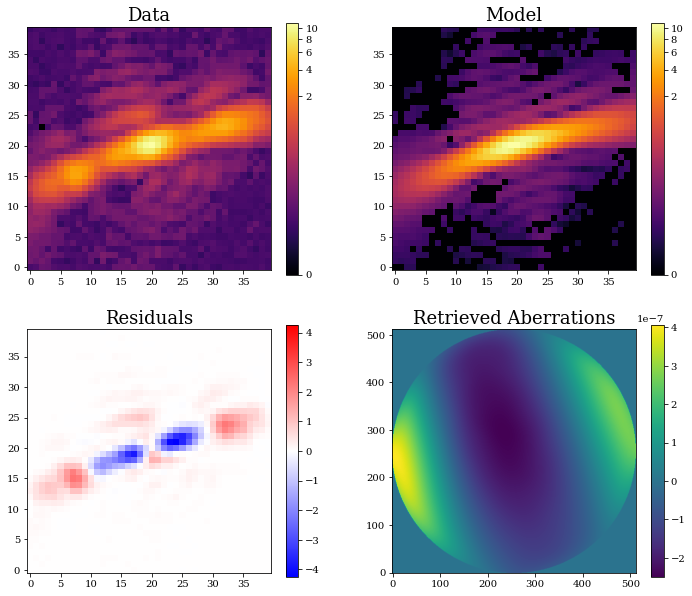

In [7]:
green_coeffs = dict.fromkeys([1,2])
red_coeffs = dict.fromkeys([1,2])

for i in range(len(img_fnames)):
    ###---------------------------- Re-init model ----------------------------###
    instrument = dl.Telescope(optics, ('source', src))
    sim_psf = instrument.model()

    ###------------------------------- Load data -----------------------------###
    data = np.load(img_fnames[i])
    data = data[still_frame_idxs[i],:,:] # using the most still frame (find_still_frame.py)

    bckgnd = np.load(bckgnd_fnames[i])
    bckgnd = np.mean(bckgnd)
    data = data - bckgnd

    data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
    data_lin = np.power((data_remapped-np.flip(alpha_cropped))/np.flip(beta_cropped), (1/np.flip(gamma_cropped))) # flip about origin

    # Scale intensity
    data = data_lin
    current_range = data.max() - data.min()
    new_range = sim_psf.max() - sim_psf.min()
    scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()

    psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
    scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(scaled_data, norm=norm_psf)
    plt.colorbar()
    plt.title("Data (scaled)")
    plt.subplot(1,2,2)
    plt.imshow(sim_psf, norm=norm_psf)
    plt.colorbar()
    plt.title("Simulated")

    ###------------------------------- Phase Retrieval -----------------------------###
    optim, opt_state = zdx.get_optimiser(instrument, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

    progress_bar = tqdm(range(epochs[i]), desc='Loss: ')

    # Run optimisation loop 
    net_losses, Coeffs, Positions, Fluxes= [],[],[],[]
    for j in progress_bar:
        poiss_loss, poiss_grads = loss_fn_poisson(model = instrument, data = scaled_data)

        updates, opt_state = optim.update(poiss_grads, opt_state)
        instrument = zdx.apply_updates(instrument, updates) 

        net_losses.append(poiss_loss)
        Fluxes.append(instrument.source.flux)
        Coeffs.append(instrument.aperture.coefficients)
        Positions.append(instrument.source.position)

        progress_bar.set_postfix({'Loss': poiss_loss})
    ###---------------------------------- Plotting ---------------------------------###
    plt.figure(figsize=(11,3))
    plt.subplot(1,4,1)
    plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
    plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
    plt.title("Position")
    plt.legend()
    plt.subplot(1,4,2)
    arr_coeffs = np.asarray(Coeffs)
    for k in range(len(Coeffs[0])):
        label = "Coeff " + str(zernike_indicies[k])
        plt.plot(arr_coeffs[:,k], label=label)
    plt.legend()
    plt.subplot(1,4,3)
    plt.plot(np.asarray(Fluxes))
    plt.title("Flux")
    plt.subplot(1,4,4)
    plt.plot(np.array(net_losses))
    ax = plt.gca()
    ax.set_title("Training History")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Poisson Log-Likelihood")


    plt.figure(figsize=(12,10))
    norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
    plt.subplot(2,2,1)
    plt.imshow(scaled_data, norm=norm_psf)
    plt.colorbar()
    plt.title('Data')

    plt.subplot(2,2,2)
    model_psf = instrument.model()
    current_range = model_psf.max() - model_psf.min()
    new_range = scaled_data.max() - scaled_data.min()
    model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
    norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
    mask = np.ones(scaled_data.shape)
    mask[scaled_data < 0.01] = 0
    plt.imshow(model_psf*mask, norm=norm_psf)
    plt.title('Model')
    plt.colorbar()

    plt.subplot(2,2,3)
    resid = scaled_data - model_psf
    plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
    plt.colorbar()
    plt.title('Residuals')

    plt.subplot(2,2,4)
    opd = instrument.aperture.eval_basis()
    plt.imshow(opd*transmission, cmap='viridis')
    plt.title('Retrieved Aberrations')
    plt.colorbar()


    print("Optimised Position: {}\nFlux: {}\nCoefficients: {}".format(instrument.source.position, instrument.source.flux, instrument.aperture.coefficients))

    if 'green' in img_fnames[i]:
        if 'starphire1' in img_fnames[i]:
            green_coeffs[1] = instrument.aperture.coefficients
        elif 'starphire2' in img_fnames[i]:
            green_coeffs[2] = instrument.aperture.coefficients
        else:
            ValueError("Unknown starphire")
    elif 'red' in img_fnames[i]:
        if 'starphire1' in img_fnames[i]:
            red_coeffs[1] = instrument.aperture.coefficients
        elif 'starphire2' in img_fnames[i]:
            red_coeffs[2] = instrument.aperture.coefficients
        else:
            ValueError("Unknown starphire")
    else:
        ValueError("Unknown wavel")

Text(0.5, 0, 'Zernike Noll Index')

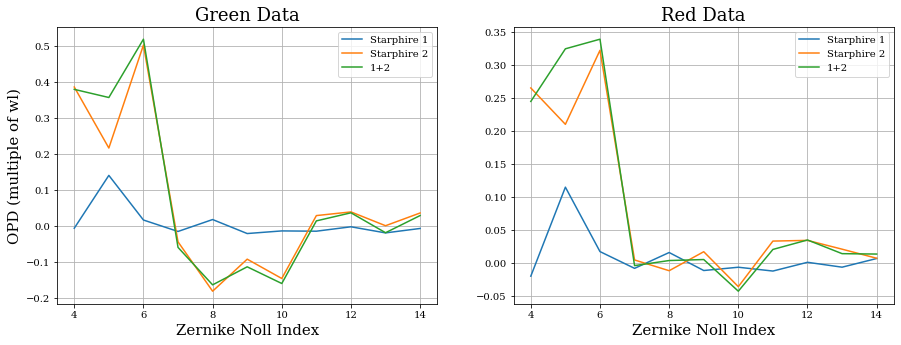

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Green Data")
plt.plot(zernike_indicies, green_coeffs[1]/green_laser_wl, label="Starphire 1")
plt.plot(zernike_indicies, green_coeffs[2]/green_laser_wl, label="Starphire 2")
plt.plot(zernike_indicies, (green_coeffs[1]+green_coeffs[2])/green_laser_wl, label="1+2")
plt.xlabel("Zernike Noll Index")
plt.ylabel("OPD (multiple of wl)")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("Red Data")
plt.plot(zernike_indicies, red_coeffs[1]/red_laser_wl, label="Starphire 1")
plt.plot(zernike_indicies, red_coeffs[2]/red_laser_wl, label="Starphire 2")
plt.plot(zernike_indicies, (red_coeffs[1]+red_coeffs[2])/red_laser_wl, label="1+2")
plt.legend()
plt.grid()
plt.xlabel("Zernike Noll Index")


#### Glued plates

In [9]:
# re-init sim with bigger fov
# Simulated Detector
psf_npix = 150                 # Number of pixels along one dim of the PSF
psf_hlf_sz = int(psf_npix/2)   # half window sz of cropped data

# Construct Optics
optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)


instrument = dl.Telescope(optics, ('source', src))
sim_psf = instrument.model()


In [14]:
# Location on detector 
row_start, col_start = 1670, 2580 # Start coord of window on det where data was taken
row_len, col_len =500,500   # window size of recorded data

alpha_cropped = alpha[row_start:row_start+row_len, col_start:col_start+col_len]
beta_cropped = beta[row_start:row_start+row_len, col_start:col_start+col_len]
gamma_cropped = gamma[row_start:row_start+row_len, col_start:col_start+col_len]

img_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/glued/15_08_green_149us_19.5gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/glued/15_08_red_149us_19.5gain_img_stack_batch_0.npy",
]
bckgnd_fnames = [
    "/Volumes/Morgana2/gpir9156/toliman/glued/15_08_bckgnd_149us_19.5gain_img_stack_batch_0.npy",
    "/Volumes/Morgana2/gpir9156/toliman/glued/15_08_bckgnd_149us_19.5gain_img_stack_batch_0.npy",
]
still_frame_idxs = [
    32,36 # find_still_frame.py
]
epochs = [
    10000, 5000
]

Loss:   0%|          | 0/10000 [00:00<?, ?it/s]

Optimised Position: [[ 8.39294021e-06 -4.23143587e-06]]
Flux: [8.59957766e+08]
Coefficients: [-3.32180893e-07  1.87693677e-07 -2.64863644e-07  5.81923942e-08
 -8.46740812e-08  1.10634905e-07  1.32958534e-07 -3.45313417e-08
 -9.49884713e-09  2.23187083e-08  6.05993531e-08]


Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimised Position: [[-2.10278223e-06  1.77467012e-06]]
Flux: [8.37690023e+08]
Coefficients: [ 3.13208282e-08 -8.95076845e-08  1.04848315e-07 -3.53409625e-08
 -9.74096439e-08 -1.10498849e-07 -9.64117410e-08 -3.50909392e-08
 -6.44312663e-08  8.22622414e-09 -7.47716337e-08]


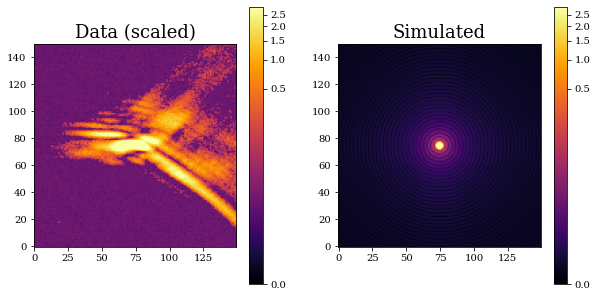

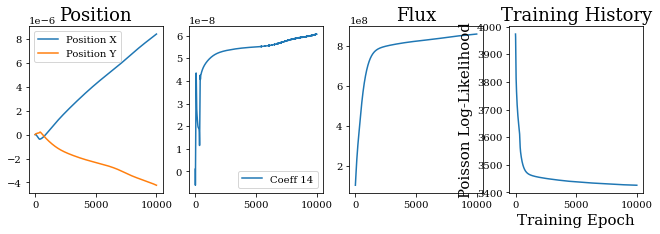

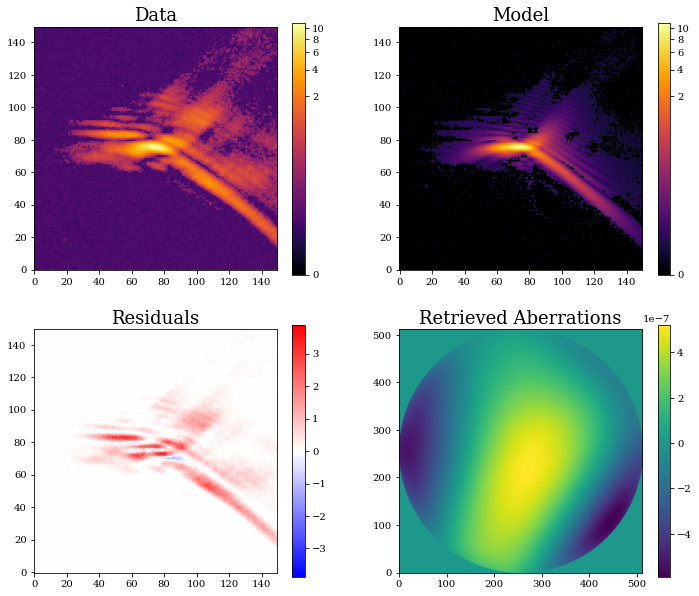

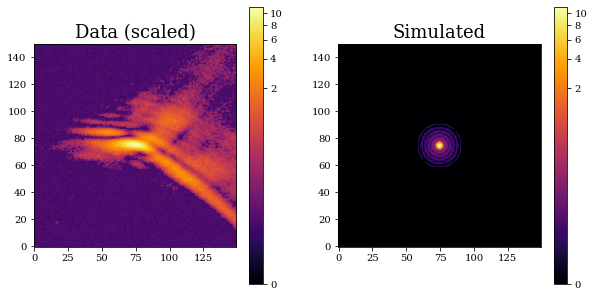

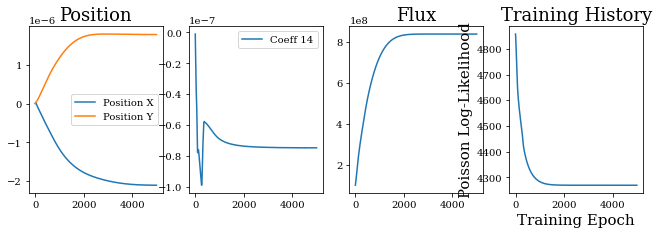

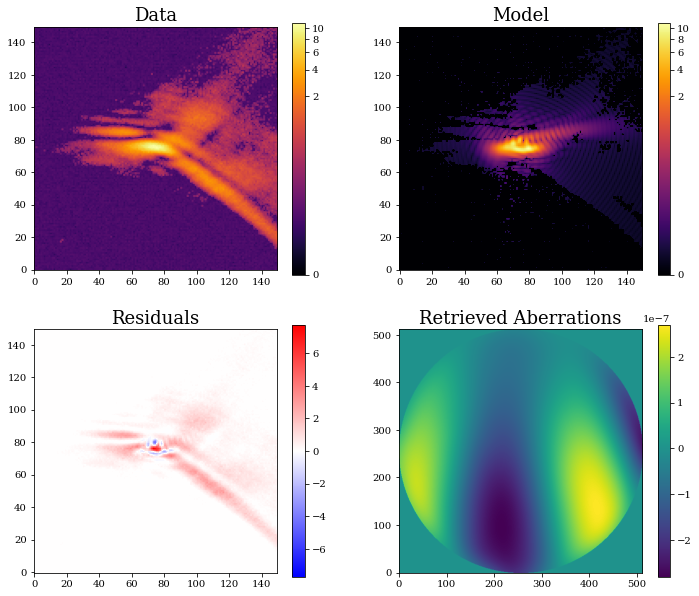

In [15]:
green_glued_coeffs = None
red_glued_coeffs = None

for i in range(len(img_fnames)):
    ###---------------------------- Re-init model ----------------------------###
    instrument = dl.Telescope(optics, ('source', src))
    sim_psf = instrument.model()

    ###------------------------------- Load data -----------------------------###
    data = np.load(img_fnames[i])
    data = data[still_frame_idxs[i],:,:] # using the most still frame (find_still_frame.py)

    bckgnd = np.load(bckgnd_fnames[i])
    bckgnd = np.mean(bckgnd)
    data = data - bckgnd

    data_remapped = 0.0 + ((1.0 - 0.0)/(data.max()-data.min()))*(data - data.min()) #[0,1] otput range
    data_lin = np.power((data_remapped-np.flip(alpha_cropped))/np.flip(beta_cropped), (1/np.flip(gamma_cropped))) # flip about origin

    # Scale intensity
    data = data_lin
    current_range = data.max() - data.min()
    new_range = sim_psf.max() - sim_psf.min()
    scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()

    psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
    scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(scaled_data, norm=norm_psf)
    plt.colorbar()
    plt.title("Data (scaled)")
    plt.subplot(1,2,2)
    plt.imshow(sim_psf, norm=norm_psf)
    plt.colorbar()
    plt.title("Simulated")

    ###------------------------------- Phase Retrieval -----------------------------###
    optim, opt_state = zdx.get_optimiser(instrument, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

    progress_bar = tqdm(range(epochs[i]), desc='Loss: ')

    # Run optimisation loop 
    net_losses, Coeffs, Positions, Fluxes= [],[],[],[]
    for j in progress_bar:
        poiss_loss, poiss_grads = loss_fn_poisson(model = instrument, data = scaled_data)

        updates, opt_state = optim.update(poiss_grads, opt_state)
        instrument = zdx.apply_updates(instrument, updates) 

        net_losses.append(poiss_loss)
        Fluxes.append(instrument.source.flux)
        Coeffs.append(instrument.aperture.coefficients)
        Positions.append(instrument.source.position)

        progress_bar.set_postfix({'Loss': poiss_loss})
    ###---------------------------------- Plotting ---------------------------------###
    plt.figure(figsize=(11,3))
    plt.subplot(1,4,1)
    plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
    plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
    plt.title("Position")
    plt.legend()
    plt.subplot(1,4,2)
    arr_coeffs = np.asarray(Coeffs)
    for k in range(len(Coeffs[0])):
        label = "Coeff " + str(zernike_indicies[k])
    plt.plot(arr_coeffs[:,k], label=label)
    plt.legend()
    plt.subplot(1,4,3)
    plt.plot(np.asarray(Fluxes))
    plt.title("Flux")
    plt.subplot(1,4,4)
    plt.plot(np.array(net_losses))
    ax = plt.gca()
    ax.set_title("Training History")
    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("Poisson Log-Likelihood")


    plt.figure(figsize=(12,10))
    norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
    plt.subplot(2,2,1)
    plt.imshow(scaled_data, norm=norm_psf)
    plt.colorbar()
    plt.title('Data')

    plt.subplot(2,2,2)
    model_psf = instrument.model()
    current_range = model_psf.max() - model_psf.min()
    new_range = scaled_data.max() - scaled_data.min()
    model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
    norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
    mask = np.ones(scaled_data.shape)
    mask[scaled_data < 0.01] = 0
    plt.imshow(model_psf*mask, norm=norm_psf)
    plt.title('Model')
    plt.colorbar()

    plt.subplot(2,2,3)
    resid = scaled_data - model_psf
    plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
    plt.colorbar()
    plt.title('Residuals')

    plt.subplot(2,2,4)
    opd = instrument.aperture.eval_basis()
    plt.imshow(opd*transmission, cmap='viridis')
    plt.title('Retrieved Aberrations')
    plt.colorbar()


    print("Optimised Position: {}\nFlux: {}\nCoefficients: {}".format(instrument.source.position, instrument.source.flux, instrument.aperture.coefficients))

    if 'green' in img_fnames[i]:
        green_glued_coeffs = instrument.aperture.coefficients
    elif 'red' in img_fnames[i]:
        red_glued_coeffs = instrument.aperture.coefficients
    else:
        ValueError("Unknown wavel")

Text(0.5, 0, 'Zernike Noll Index')

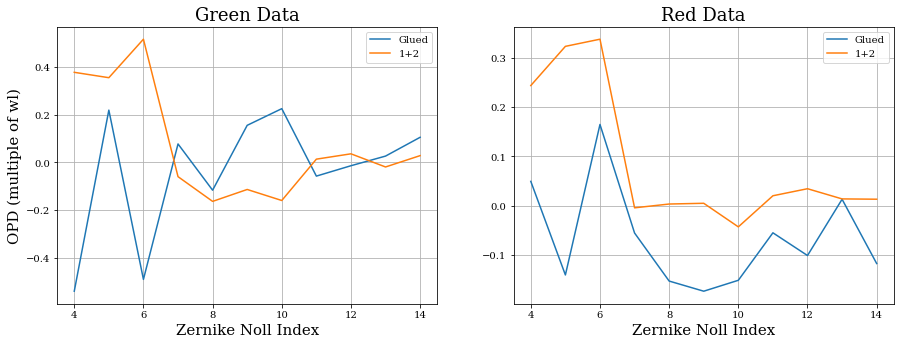

In [12]:
# coeffs comparison
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Green Data")
plt.plot(zernike_indicies, green_glued_coeffs/green_laser_wl, label="Glued")
plt.plot(zernike_indicies, (green_coeffs[1]+green_coeffs[2])/green_laser_wl, label="1+2")
plt.xlabel("Zernike Noll Index")
plt.ylabel("OPD (multiple of wl)")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.title("Red Data")
plt.plot(zernike_indicies, red_glued_coeffs/red_laser_wl, label="Glued")
plt.plot(zernike_indicies, (red_coeffs[1]+red_coeffs[2])/red_laser_wl, label="1+2")
plt.legend()
plt.grid()
plt.xlabel("Zernike Noll Index")

Glued wf error: 0.9836927930382663lambda
Starphire 1: 0.147645872145329lambda, Starphire 2: 0.7178280963199677lambda


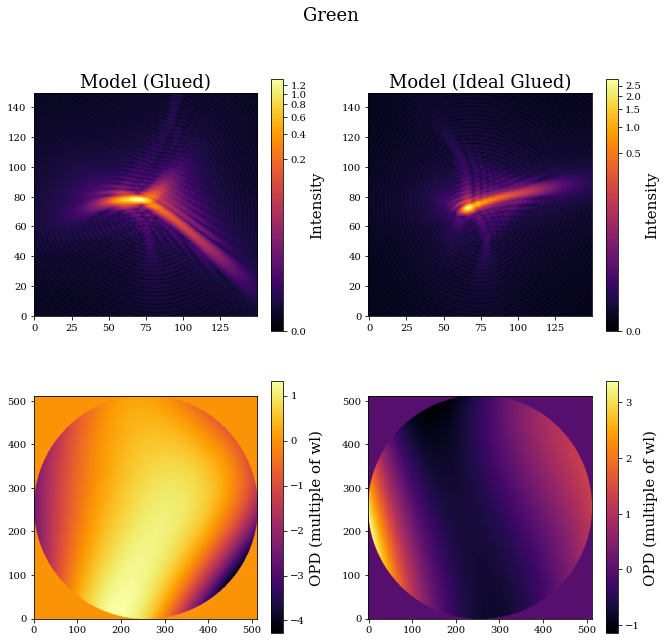

In [18]:
# PSF comparsion (just one colour for now)
%matplotlib inline
plt.figure(figsize=(11,10))
plt.suptitle("Green")
plt.subplot(2,2,1)
plt.title("Model (Glued)")
instrument = dl.Telescope(optics, ('source', src))
instrument = instrument.set('aperture.coefficients', green_glued_coeffs)
model_psf = instrument.model()
norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
plt.imshow(model_psf, norm=norm_psf)
plt.colorbar(label="Intensity")

plt.subplot(2,2,3)
opd = instrument.aperture.eval_basis()
plt.imshow(opd/green_laser_wl)
plt.colorbar(label="OPD (multiple of wl)")

RMS_wf_err0 = ((green_glued_coeffs**2).sum())**0.5
print("Glued wf error: {}lambda".format(RMS_wf_err0/green_laser_wl))
RMS_wf_err1 = ((green_coeffs[1]**2).sum())**0.5
RMS_wf_err2 = ((green_coeffs[2]**2).sum())**0.5
print("Starphire 1: {}lambda, Starphire 2: {}lambda".format(RMS_wf_err1/green_laser_wl, RMS_wf_err2/green_laser_wl))

plt.subplot(2,2,2)
plt.title("Model (Ideal Glued)")
instrument = dl.Telescope(optics, ('source', src))
tot_z = green_coeffs[1]+green_coeffs[2]
instrument = instrument.set('aperture.coefficients', tot_z)
model_psf = instrument.model()
norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
plt.imshow(model_psf, norm=norm_psf)
plt.colorbar(label="Intensity")

plt.subplot(2,2,4)
opd = instrument.aperture.eval_basis()
plt.imshow(opd/green_laser_wl)
plt.colorbar(label="OPD (multiple of wl)")

